# Matrix Factorization using Bregman Divergenses

## Testing NMF class

In [1]:
from sklearn.decomposition import NMF as nmfsk
from MatrixFactorization import NMF as nmfmy
import numpy as np
from numpy.random import RandomState
from sklearn.metrics import mean_squared_error
from math import sqrt

## 1. Gaussian Distribution

### 1.1 Selecting best way to represent Gaussian Distribution with Non- negative Values

Gaussian Distribution from definition varies from negative infinity to positive infinity. Since NMF requires data with non-negative values this causes problems. To handle this i examine two different approaches for having data with non-negative values that approach a normal distribution.

#### 1.1a Take the absolute value

First i try taking the abolute value of all data from a normal distribution. The results as shown by the graph below where near a normal distribution but at the left of the mean the result was not encouraged.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
rs = RandomState(76321654)
V = rs.normal(5,3.14,10000).reshape(200,50)
V = np.abs(V)
sns.set(color_codes=True)
sns.distplot(V[4])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


#### 1.1b Add the absolute of the MIN

The other approach was adding the absolute of the min value. This ensures that all values will be non-negative and also it tries to keep the distribution as it was by shifting the data to the right.

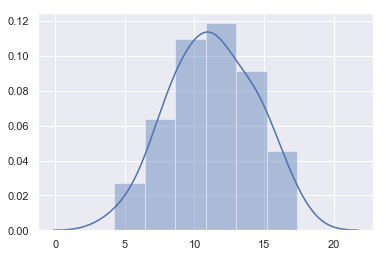

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
rs = RandomState(76321654)
V = rs.normal(5,3.14,10000).reshape(200,50)
V = np.add(V,abs(np.min(V)))
sns.set(color_codes=True)
sns.distplot(V[4])


As can be seen from the above graphs the second way provides better approximation of a normal distribution with non-negative values. Thus the second approach will be used throughout for producing non-negative data resampling normal distribution. 

In [4]:
def normal_positive_data(rows, columns, mean=5, std=3.14):
    
    rs = RandomState(76321654)
    V = rs.normal(mean,std,rows * columns).reshape(rows,columns)
    V = np.add(V,abs(np.min(V)))
    return V

### 1.2 Test NMF for Data coming from Normal Distribution

In [5]:
V = normal_positive_data(rows = 200 , columns = 50, mean=5, std=3.14)
n = 10

#### LOG Likelihood as taken from http://mikkelschmidt.dk/presentations/nmfgppcam.pdf

In [6]:
import math
def neg_log_likelihood_normal(V,W,H):
    st = np.std(V)
    const = V.shape[0] * V.shape[1] * np.log((2*math.pi)**2 *st)
    lpart = np.sum( (V - W.dot(H))**2  / (2* st**2) )
    l = const + lpart
    return l

### Sklearn Implementation

In [7]:
rs = RandomState(76321654)
nmfS = nmfsk(n_components=n,random_state=rs)
Ws = nmfS.fit_transform(V)
Hs = nmfS.components_

diffS = mean_squared_error(V, Ws.dot(Hs))
print('Mean Squared Error Between Sklearn Results and V :' + str(diffS))

Mean Squared Error Between Sklearn Results and V :6.562692324680992


### My Implementation

In [8]:
rs = RandomState(76321654)
nmfM = nmfmy(n_components=n,random_state=rs, distribution = 'gaussian')
W, H = nmfM.fit_transform(V)
diffM = mean_squared_error(V, W.dot(H))
print('Mean Squared Error Between My Results and V :' + str(diffM))

Mean Squared Error Between My Results and V :6.902009417662166


### Combination of My and Sklearn

In [9]:
from MatrixFactorization import myNMF as nmfmy2
rs = RandomState(76321654)
nmfM2 = nmfmy2(n_components=n,random_state=rs, distribution = 'gaussian')
W2 = nmfM2.fit_transform(V)
H2 = nmfM2.components_

diffM2 =mean_squared_error(V, W2.dot(H2))
print('Mean Squared Error Between My Results and V :' + str(diffM2))

Mean Squared Error Between My Results and V :7.271711886818696


### Compare the three Approaches

In [10]:
errorssk = np.zeros(50)
errorsmy = np.zeros(50)
errorsmy2 = np.zeros(50)
lsk = np.zeros(50)
lmy = np.zeros(50)
lmy2 = np.zeros(50)
psk = np.zeros(50)
pmy = np.zeros(50)
pmy2 = np.zeros(50)

for n in range(1, 51):
    print(n)
    rs = RandomState(76321654)
    
    # Sklearn
    nmfS = nmfsk(n_components=n,random_state=rs)
    Ws = nmfS.fit_transform(V)
    Hs = nmfS.components_
    
    #My 
    rs = RandomState(76321654)
    nmfM = nmfmy(n_components=n,random_state=rs)
    W, H = nmfM.fit_transform(V)
    
    #Combination
    rs = RandomState(76321654)
    nmfM2 = nmfmy2(n_components=n,random_state=rs)
    W2 = nmfM2.fit_transform(V)
    H2 = nmfM2.components_
    
    
    # Mean Squared Errors 
    diffS = mean_squared_error(V, Ws.dot(Hs))
    errorssk[n-1] = diffS
    diffM = mean_squared_error(V, W.dot(H))
    errorsmy[n-1] = diffM
    diffM2 =mean_squared_error(V, W2.dot(H2))
    errorsmy2[n-1] = diffM2
    
    # Average Neg Log Likelihoods
    diffS = neg_log_likelihood_normal(V, Ws, Hs)
    lsk[n-1] = diffS / (V.shape[0] * V.shape[1])
    
    diffM = neg_log_likelihood_normal(V, W, H)
    lmy[n-1] = diffM / (V.shape[0] * V.shape[1])
    
    diffM2 =neg_log_likelihood_normal(V, W2 , H2)
    lmy2[n-1] = diffM2 / (V.shape[0] * V.shape[1])
    
    # Avg Probability for log likelihood
    diffS = neg_log_likelihood_normal(V, Ws, Hs)
    psk[n-1] = math.e ** (-diffS / (V.shape[0] * V.shape[1]))
    
    diffM = neg_log_likelihood_normal(V, W, H)
    pmy[n-1] = math.e ** (-diffM / (V.shape[0] * V.shape[1]))
    
    diffM2 =neg_log_likelihood_normal(V, W2 , H2)
    pmy2[n-1] = math.e ** (-diffM2 / (V.shape[0] * V.shape[1]))
    
    
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


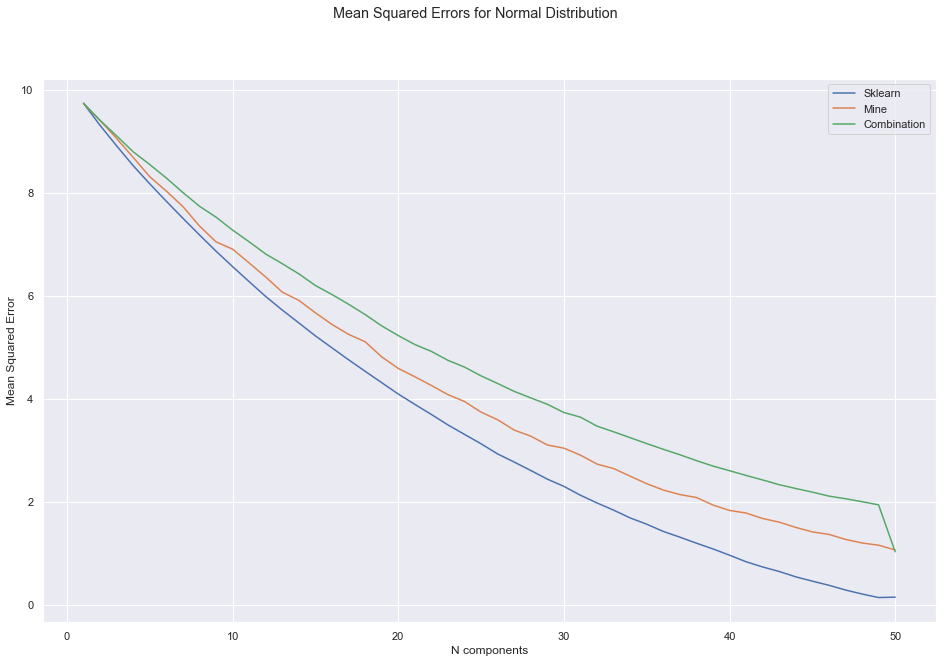

In [11]:
fig_1 = plt.figure(figsize=(16, 10))
ax_1 = fig_1.add_subplot(111)
    
ax_1.plot(np.arange(1, 51), 
                  errorssk, label="Sklearn")
ax_1.plot(np.arange(1, 51), 
                  errorsmy, label="Mine")
ax_1.plot(np.arange(1, 51), 
                  errorsmy2, label="Combination")
ax_1.legend(loc=0)

ax_1.set_xlabel('N components')
ax_1.set_ylabel('Mean Squared Error')
fig_1.suptitle('Mean Squared Errors for Normal Distribution')
fig_1.savefig('MeanSquaredErrorsForNMFNormal1.pdf')

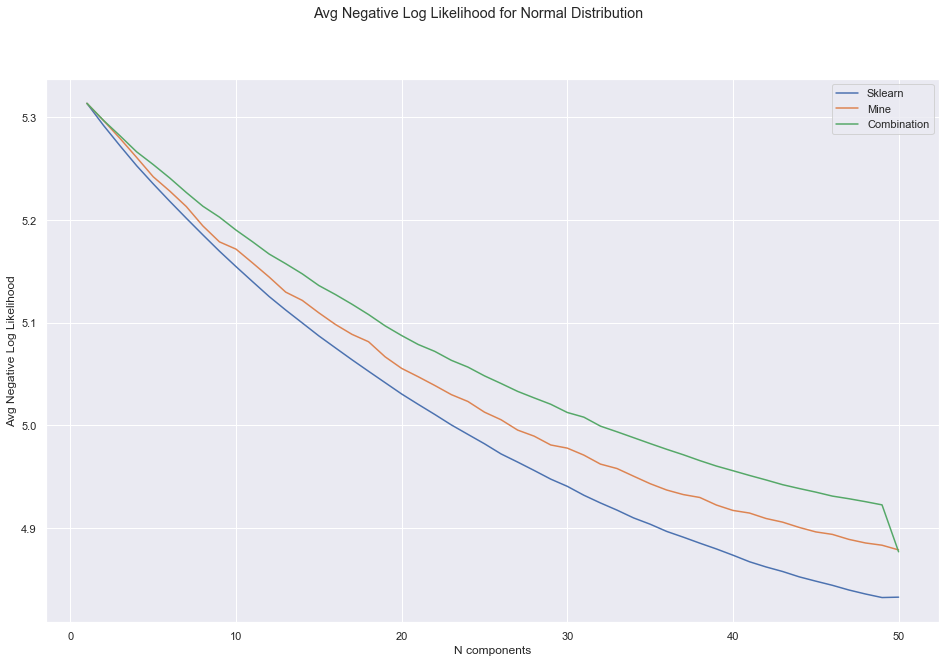

In [12]:
fig_1 = plt.figure(figsize=(16, 10))
ax_1 = fig_1.add_subplot(111)
    
ax_1.plot(np.arange(1, 51), 
                  lsk, label="Sklearn")
ax_1.plot(np.arange(1, 51), 
                  lmy, label="Mine")
ax_1.plot(np.arange(1, 51), 
                  lmy2, label="Combination")
ax_1.legend(loc=0)

ax_1.set_xlabel('N components')
ax_1.set_ylabel('Avg Negative Log Likelihood')
fig_1.suptitle('Avg Negative Log Likelihood for Normal Distribution')
fig_1.savefig('AverageNegLogLikelihoodForNMFNormal1.pdf')

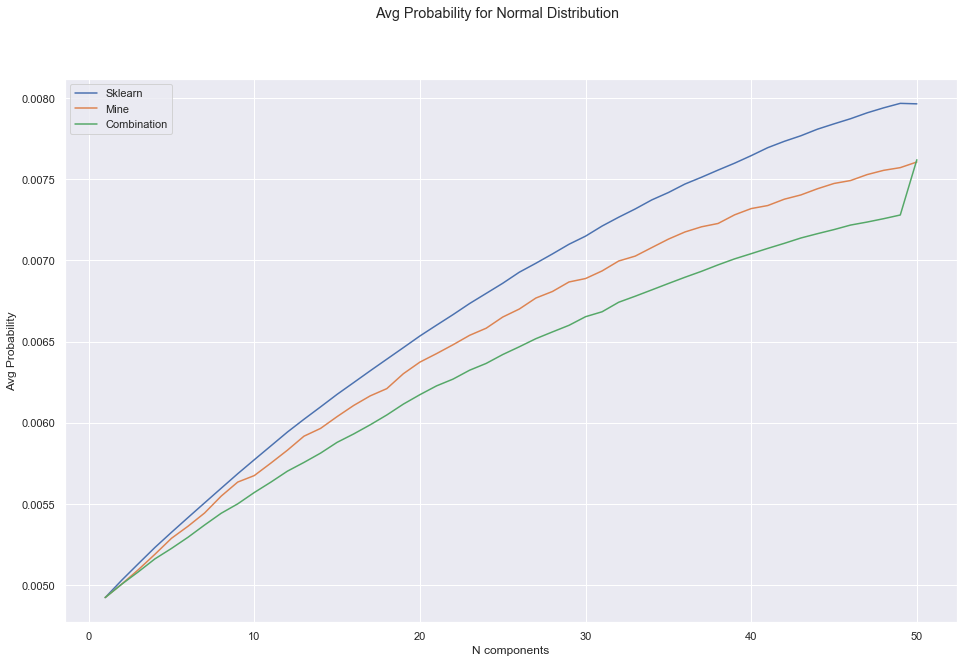

In [13]:
fig_1 = plt.figure(figsize=(16, 10))
ax_1 = fig_1.add_subplot(111)
    
ax_1.plot(np.arange(1, 51), 
                  psk, label="Sklearn")
ax_1.plot(np.arange(1, 51), 
                  pmy, label="Mine")
ax_1.plot(np.arange(1, 51), 
                  pmy2, label="Combination")
ax_1.legend(loc=0)

ax_1.set_xlabel('N components')
ax_1.set_ylabel('Avg Probability')
fig_1.suptitle('Avg Probability for Normal Distribution')
fig_1.savefig('AverageProbabilityNMFNormal1.pdf')

#### Distribution compared to Sklearn with 10 components

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Original Data mean: 11.620873774806372 std: 3.1572744919693414
Tansformation Data : 11.6281106536918 std: 1.8185983661225287


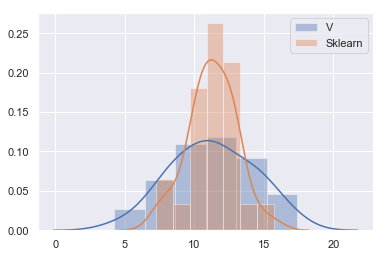

In [14]:
rs = RandomState(76321654)
n = 10
nmfS = nmfsk(n_components=n,random_state=rs)
Ws = nmfS.fit_transform(V)
Hs = nmfS.components_
sns.set(color_codes=True)
sns.distplot(V[4], label ='V')
sns.distplot(Ws.dot(Hs)[4], label='Sklearn')
plt.legend()
print('Original Data mean: ' + str(V.mean()) + ' std: ' + str(V.std()) )
print('Tansformation Data : ' + str(Ws.dot(Hs).mean()) + ' std: ' + str(Ws.dot(Hs).std()) )

#### Distribution compared to Mine with 10 components

Original Data mean: 11.620873774806372 std: 3.1572744919693414
Tansformation Data : 11.62896221436468 std: 1.6963097420772377


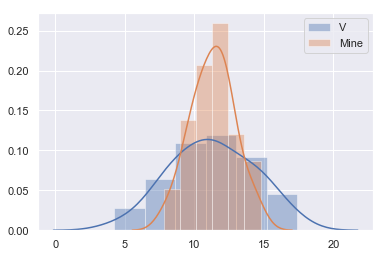

In [15]:
rs = RandomState(76321654)
n = 10
rs = RandomState(76321654)
nmfM = nmfmy(n_components=n,random_state=rs)
W, H = nmfM.fit_transform(V)
sns.set(color_codes=True)
sns.distplot(V[4], label = 'V')
sns.distplot(W.dot(H)[4], label ='Mine')
plt.legend()
print('Original Data mean: ' + str(V.mean()) + ' std: ' + str(V.std()) )
print('Tansformation Data : ' + str(W.dot(H).mean()) + ' std: ' + str(W.dot(H).std()) )

#### Distribution compared to Combination with 10 components

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Original Data mean: 11.620873774806372 std: 3.1572744919693414
Tansformation Data : 11.622166780327102 std: 1.6329682472576534


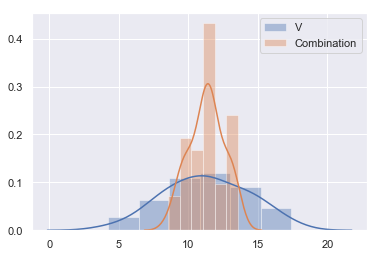

In [16]:
from MatrixFactorization import myNMF as nmfmy2
rs = RandomState(76321654)
nmfM2 = nmfmy2(n_components=n,random_state=rs)
W2 = nmfM2.fit_transform(V)
H2 = nmfM2.components_
sns.set(color_codes=True)
sns.distplot(V[4],label='V')
sns.distplot(W2.dot(H2)[4], label = 'Combination')
plt.legend()
print('Original Data mean: ' + str(V.mean()) + ' std: ' + str(V.std()) )
print('Tansformation Data : ' + str(W2.dot(H2).mean()) + ' std: ' + str(W2.dot(H2).std()) )